In [26]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch as th
# import torchmetrics as thm
import LPGNN
import igraph as ig
import networkx as nx
import torch_geometric as pyg

import pyarrow as pa
import pyarrow.parquet as pq

import importlib
import powerlaw

import imageio

from tqdm import tqdm

In [75]:
importlib.reload(LPGNN.popularity_similarity)
importlib.reload(LPGNN.embedding)
importlib.reload(LPGNN.poincare_embedding)
importlib.reload(LPGNN.distances)
importlib.reload(LPGNN.visualization.degree_distribution)
importlib.reload(LPGNN.visualization)
importlib.reload(LPGNN.utils)
importlib.reload(LPGNN.labne)
importlib.reload(LPGNN.graph_metrics)
importlib.reload(LPGNN.DataSetup)
importlib.reload(LPGNN.tree_pruning)
importlib.reload(LPGNN.LinkPrediction)
importlib.reload(LPGNN.lorentz_embedding)

<module 'LPGNN.lorentz_embedding' from '/home/mf/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/lorentz_embedding.py'>

In [27]:
seed = 47

In [3]:
N = 600
avg_k = 8
gamma = 2.7
T = 0.0
seed += 1
PS = LPGNN.popularity_similarity.generatePSNetwork(N, avg_k, gamma, T, seed)

In [186]:
PS = LPGNN.DataSetup.train_test_split(PS, test_ratio=0.4, val_ratio=0, neg_samples=False)
PS_nx = pyg.utils.to_networkx(PS, to_undirected=True)
nx.is_connected(PS_nx)

True

In [72]:
PS_Poincare = LPGNN.lorentz_embedding.lorentz_embedding(PS, epochs=10, dim=10)

100%|██████████| 10/10 [00:00<00:00, 1685.61it/s]

Calculating best minimal value for power law fit


In [74]:
PS_Poincare = LPGNN.poincare_embedding.poincare_embedding(PS, epochs=1, dim=10)

100%|██████████| 1/1 [00:00<00:00, 202.83it/s]

[300, 10]
0.01 *
-0.1688 -0.5843  0.3319  0.1176 -0.2178  0.0470  0.1024  0.0266  0.4970 -0.3365
 -0.0839 -0.1415 -0.4991 -0.0604 -0.3123 -0.5082  0.0205  0.4474 -0.2860 -0.0328
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.1099 -0.3674  0.2657  0.0854  0.0743  0.3578  0.3961 -0.3335  0.4336  0.3273
  0.3692 -0.2691  0.4567 -0.0340 -0.1948 -0.0119  0.3967 -0.4093  0.3334  0.1769
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.1166 -0.4907  0.2954 -0.3436  0.0072  0.0132  0.5040  0.0639  0.3006  0.3297
  0.2324  1.5258 -2.5037 -2.1781  2.2892 -0.9268  0.0104  1.1083 -0.7689  1.6373
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.

In [4]:
PS_LaBNE = LPGNN.labne.generateLaBNE(PS, normalize_radius=0.1)

Calculating best minimal value for power law fit


/home/mf/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/labne.py:59: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811740025/work/aten/src/ATen/native/Copy.cpp:244.)
  x_LE_cartesian = th.Tensor(eigenvectors[:,1:])


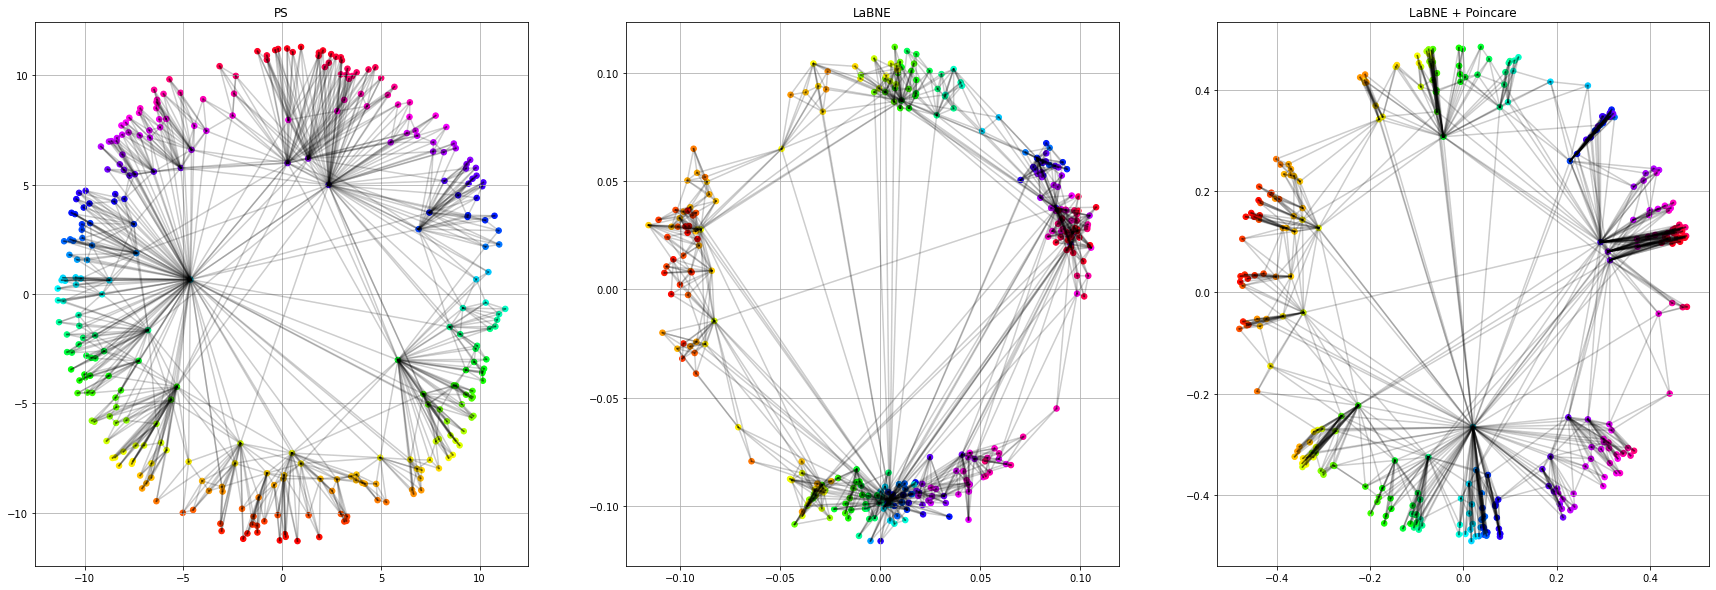

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30,10))
ax[0].grid()
ax[0].set_title('PS')
ax[1].grid()
ax[1].set_title('LaBNE')
ax[2].grid()
ax[2].set_title('LaBNE + Poincare')

nc = PS.node_positions[:,1].detach().numpy()

x_cart = PS.node_positions.detach().numpy()
ax[0].scatter(x_cart[:,0], x_cart[:,1], s=30, c=nc, cmap='hsv')
# draw edges
for i, j in PS.edge_index.T:
    ax[0].plot(x_cart[[i,j],0], x_cart[[i,j],1], color='k', alpha=0.1)

x_cart = PS_LaBNE.LaBNE_node_positions.detach().numpy()
points = ax[1].scatter(x_cart[:,0], x_cart[:,1], s=30, c=nc, cmap='hsv')
# draw edges    
for i, j in PS.edge_index.T:
    ax[1].plot(x_cart[[i,j],0], x_cart[[i,j],1], color='k', alpha=0.1)

x_cart = PS_Poincare.PoincareEmbedding_node_positions.detach().numpy()
points = ax[2].scatter(x_cart[:,0], x_cart[:,1], s=30, c=nc, cmap='hsv')
# draw edges
for i, j in PS.edge_index.T:
    ax[2].plot(x_cart[[i,j],0], x_cart[[i,j],1], color='k', alpha=0.1)

In [8]:
PS_Poincare = LPGNN.poincare_embedding.poincare_embedding(PS, epochs=0, init_pos=PS_LaBNE.LaBNE_node_positions, r_ordering=False)

max_r = PS_Poincare.PoincareEmbedding_node_polar_positions[:,0].max()
r = LPGNN.labne.radial_ordering(PS, 'edge_index')
PS_Poincare.PoincareEmbedding_node_polar_positions[:,0] = r / r.max() * max_r
PS_Poincare.PoincareEmbedding_node_positions = LPGNN.distances.to_cartesian(PS_Poincare.PoincareEmbedding_node_polar_positions)

0it [00:00, ?it/s]


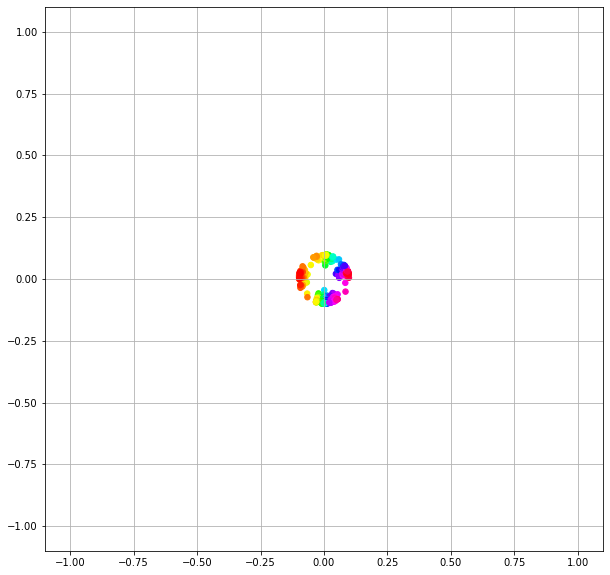

In [6]:
nc = PS.node_positions[:,1].detach().numpy()
x_cart = PS_Poincare.PoincareEmbedding_node_positions.detach().numpy()
fig, ax = plt.subplots(figsize=(10,10))
ax.grid()
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
points = ax.scatter(x_cart[:,0], x_cart[:,1], s=30, c=nc, cmap='hsv')


In [26]:
importlib.reload(LPGNN.lorentz_embedding)

<module 'LPGNN.lorentz_embedding' from '/home/mf/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/lorentz_embedding.py'>

In [27]:
PS_Lorentz = LPGNN.lorentz_embedding.lorentz_embedding(PS, epochs=1, dim=3, expm='exact', lr=0.1)

100%|██████████| 1/1 [00:00<00:00, 60.65it/s]

Calculating best minimal value for power law fit


In [28]:
PS_Lorentz.LorentzEmbedding_node_positions.grad

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

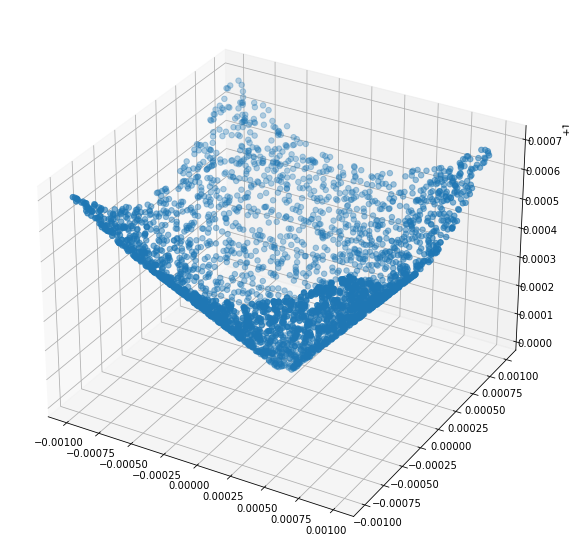

In [188]:
# plot PS_Lorentz.LorentzEmbedding_node_positions in 3D
x = PS_Lorentz.LorentzEmbedding_node_positions.detach().numpy()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,1], x[:,2], x[:,0], s=30, cmap='hsv')

In [14]:
PS_Lorentz.LorentzEmbedding_node_positions.grad

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [181]:
PS_Lorentz.LorentzEmbedding_node_positions[:,0] == th.norm(PS_Lorentz.LorentzEmbedding_node_positions[:,1:], dim=1)

tensor([False, False, False,  ..., False, False, False])

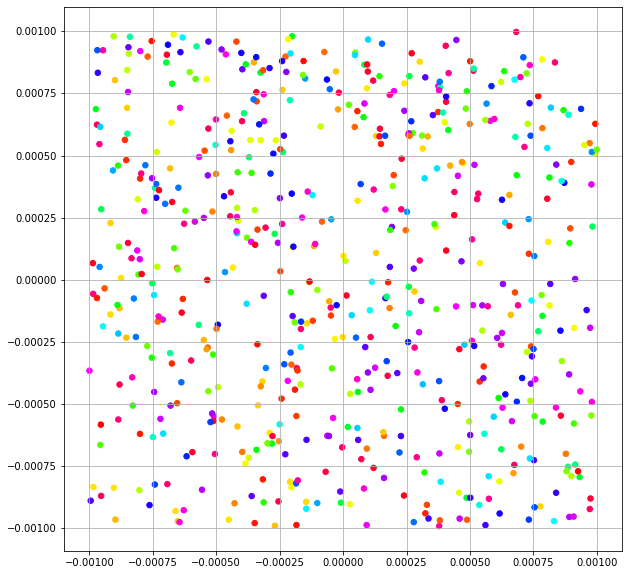

In [7]:
nc = PS.node_positions[:,1].detach().numpy()
x_cart = PS_Lorentz.LorentzEmbedding_node_positions.detach().numpy()
fig, ax = plt.subplots(figsize=(10,10))
ax.grid()
# ax.set_xlim(-1.1, 1.1)
# ax.set_ylim(-1.1, 1.1)
points = ax.scatter(x_cart[:,2], x_cart[:,1], s=30, c=nc, cmap='hsv')

In [30]:
from PIL import Image

In [33]:
im = Image.open('figs/horse.png')
im.save?

Signature: im.save(fp, format=None, **params)
Docstring:
Saves this image under the given filename.  If no format is
specified, the format to use is determined from the filename
extension, if possible.

Keyword options can be used to provide additional instructions
to the writer. If a writer doesn't recognise an option, it is
silently ignored. The available options are described in the
:doc:`image format documentation
<../handbook/image-file-formats>` for each writer.

You can use a file object instead of a filename. In this case,
you must always specify the format. The file object must
implement the ``seek``, ``tell``, and ``write``
methods, and be opened in binary mode.

:param fp: A filename (string), pathlib.Path object or file object.
:param format: Optional format override.  If omitted, the
   format to use is determined from the filename extension.
   If a file object was used instead of a filename, this
   parameter should always be used.
:param params: Extra parameters to the 

In [29]:
epoch_count = 0
for i in range(601):

    fig.suptitle(f'Epoch = {epoch_count:04}', fontsize=20)
    fig.savefig(f'figs/animations/Lorentz/PS_Lorentz_{i:04}.png')

    # map i to an epoch range that increases by a factor of 2 every 100 i steps, and is capped at 1500
    epoch = min(1500, 2**(i//100))
    epoch_count += epoch
    PS_Lorentz = LPGNN.lorentz_embedding.lorentz_embedding(PS, epochs=epoch, lr=0.001, init_pos=PS_Lorentz.LorentzEmbedding_node_positions, r_ordering=False, expm='exact')
    
    # update the points positions to the new ones
    x_cart = PS_Lorentz.LorentzEmbedding_node_positions[:,1:].detach().numpy()
    points.set_offsets(x_cart)

100%|██████████| 1/1 [00:00<00:00, 90.28it/s]


KeyboardInterrupt: 

In [31]:
with imageio.get_writer('figs/animations/Poincare/PS_Poincare.gif', mode='I', duration=0.03) as writer:
    for i in tqdm(range(1000)):
        image = imageio.imread(f'figs/animations/Poincare/LargerDisk/PS_Poincare_{i:04}.png')
        writer.append_data(image)

100%|██████████| 1000/1000 [01:14<00:00, 13.51it/s]


In [34]:
r = LPGNN.labne.radial_ordering(PS_Poincare)
PS_Poincare.PoincareEmbedding_node_polar_positions[:,0] = r

Calculating best minimal value for power law fit


(<Figure size 720x720 with 1 Axes>, <PolarAxesSubplot:>)

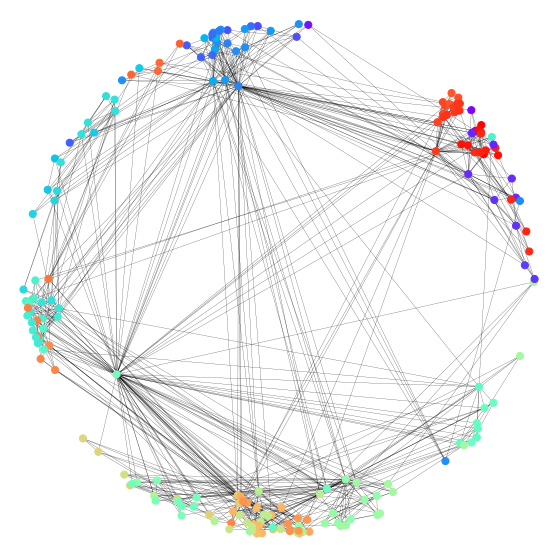

In [37]:
LPGNN.popularity_similarity.drawPSNetwork(PS_Poincare, pos_name='PoincareEmbedding_node_polar_positions', polar_projection=True)

In [72]:
# radial reordering
r = LPGNN.labne.radial_ordering(PS_Poincare)
PS_Poincare.PoincareEmbedding_node_polar_positions[:,0] = r
# stretch theta to -pi, pi
PS_Poincare.PoincareEmbedding_node_polar_positions[:,1] %= 2*np.pi
max_theta = PS_Poincare.PoincareEmbedding_node_polar_positions[:,1].max()
min_theta = PS_Poincare.PoincareEmbedding_node_polar_positions[:,1].min()
PS_Poincare.PoincareEmbedding_node_polar_positions[:,1] = (PS_Poincare.PoincareEmbedding_node_polar_positions[:,1] - min_theta) / (max_theta - min_theta) * 2 * np.pi - np.pi

Calculating best minimal value for power law fit


(<Figure size 720x720 with 1 Axes>, <PolarAxesSubplot:>)

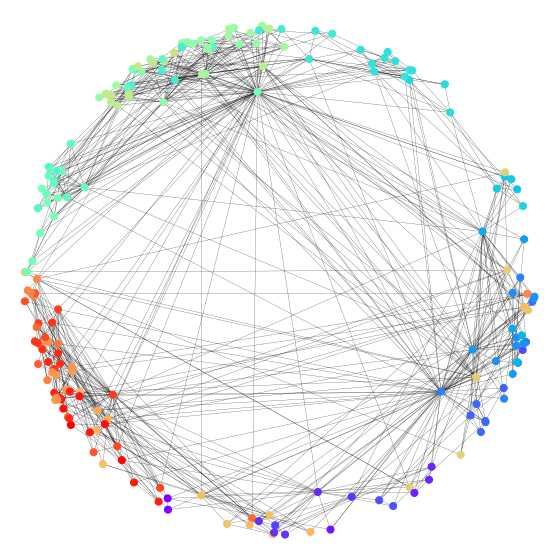

In [73]:
LPGNN.popularity_similarity.drawPSNetwork(PS_Poincare, pos_name='PoincareEmbedding_node_polar_positions', polar_projection=True)

(<Figure size 720x720 with 1 Axes>, <PolarAxesSubplot:>)

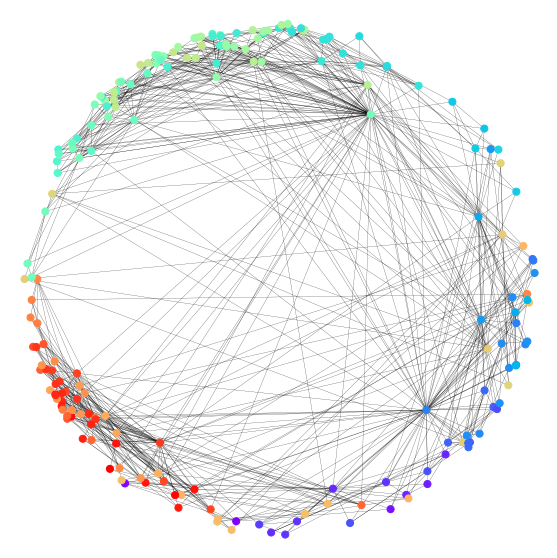

In [75]:
PS_LaBNE.LaBNE_node_polar_positions[:,1] %= 2*np.pi
max_theta = PS_LaBNE.LaBNE_node_polar_positions[:,1].max()
min_theta = PS_LaBNE.LaBNE_node_polar_positions[:,1].min()
PS_LaBNE.LaBNE_node_polar_positions[:,1] = (PS_LaBNE.LaBNE_node_polar_positions[:,1] - min_theta) / (max_theta - min_theta) * 2 * np.pi - np.pi
LPGNN.popularity_similarity.drawPSNetwork(PS_LaBNE, pos_name='LaBNE_node_polar_positions', polar_projection=True)

In [76]:
R_LaBNE, P_LaBNE = LPGNN.LinkPrediction.precision_recall_score_file(PS_LaBNE, position_name='LaBNE_node_polar_positions', filename=f'figs/animations/Poincare/PS_LaBNE', chunk_size=100, skip_file_prep=False, step_size=1)

Generating test mask...
torch.Size([316]) torch.Size([316])
Total test mask:  tensor(316.)  . Total test edges:  316
Generating hyperbolic distances and saving to file  figs/animations/PS_LaBNE
Sorting file...
Reading file and generating precision-recall curve...
index: 19022, R: 1.000, P: 0.017

In [77]:
R_Poincare, P_Poincare = LPGNN.LinkPrediction.precision_recall_score_file(PS_Poincare, position_name='PoincareEmbedding_node_polar_positions', filename=f'figs/animations/Poincare/PS_Poincare', chunk_size=100, skip_file_prep=False, step_size=1)

Generating test mask...
torch.Size([316]) torch.Size([316])
Total test mask:  tensor(316.)  . Total test edges:  316
Generating hyperbolic distances and saving to file  figs/animations/Poincare/PS_Poincare
Sorting file...
Reading file and generating precision-recall curve...
index: 17261, R: 1.000, P: 0.018

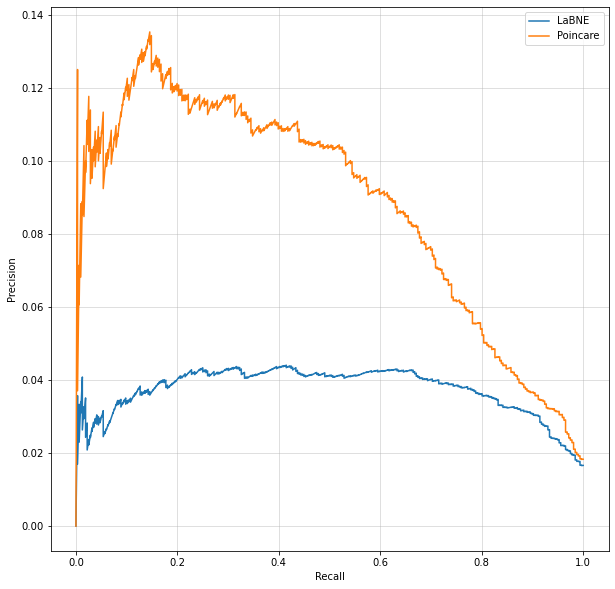

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid(alpha=0.5)

ax.plot(R_LaBNE, P_LaBNE, label='LaBNE')
ax.plot(R_Poincare, P_Poincare, label='Poincare')
#ax.plot(R_Poincare_more_epochs, P_Poincare_more_epochs, label='Poincare ME')

ax.legend()

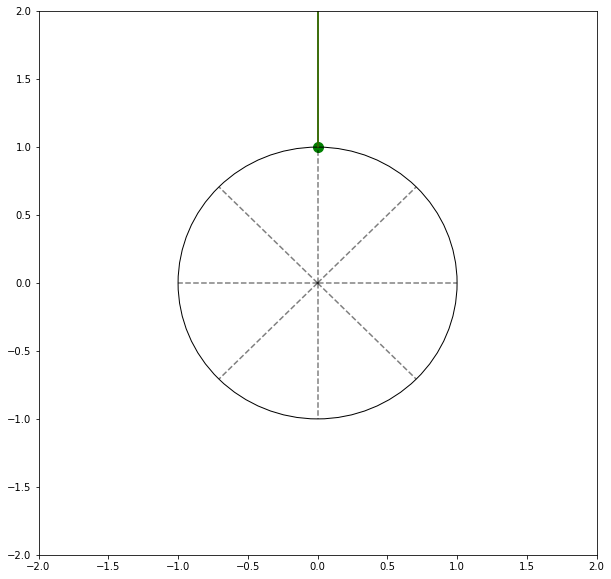

In [176]:
x = th.Tensor([0.0,1])
v = th.Tensor([0,10])
v = x + v

exp_x_v = LPGNN.poincare_embedding.exact_expm(x, v)
a_exp_x_v = LPGNN.poincare_embedding.approx_expm(x, v)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

#draw a dot at x
ax.scatter(x[0], x[1], color='g', s=100)

ax.plot([x[0], v[0]], [x[1], v[1]], 'r-')
ax.plot([x[0], exp_x_v[0]], [x[1], exp_x_v[1]], 'b-')
ax.plot([x[0], a_exp_x_v[0]], [x[1], a_exp_x_v[1]], 'g-')

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

# draw a circle of radius 1 centered at (0,0)
circle = plt.Circle((0, 0), 1, color='k', fill=False)
ax.add_artist(circle)

# draw 8 line segments from the origin to the circle
# make the segments dotted and slightly transparent
for i in range(0, 360, 45):
    ax.plot([0, np.cos(i*np.pi/180)], [0, np.sin(i*np.pi/180)], 'k--', alpha=0.5)

In [24]:
import importlib
importlib.reload(LPGNN.popularity_similarity)
import networkx as nx
import matplotlib.pyplot as plt

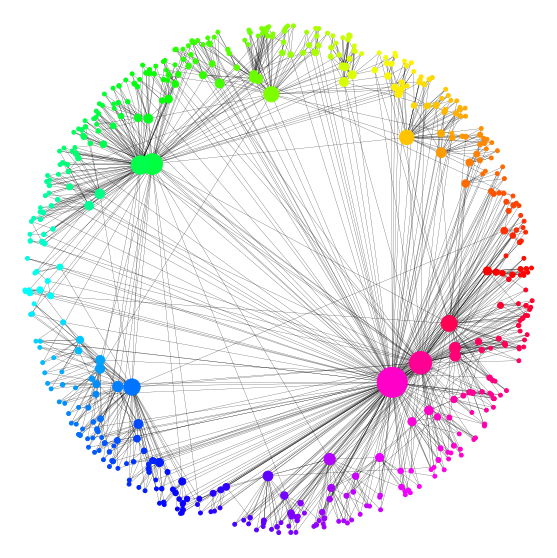

In [25]:
import LPGNN

PS = LPGNN.popularity_similarity.generatePSNetwork(N=500, avg_k=6, gamma=2.2, T=0.3, dim=2, seed=42)
LPGNN.popularity_similarity.drawPSNetwork(PS, polar_projection=True)
# save fig with high dpi
plt.savefig('website/figs/PS_N500_avgk_6_gma_2.2_T_0.3_dim_2_seed_42.png', dpi=300)